In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read BES RPS data, read BES 2024 GE results to get Region column
df = pd.read_spss('bes_rps_2024_1.0.1.sav')
region = pd.read_spss('BES-2024-General-Election-results-file-v1.0.sav', usecols=["ONSConstID", "Region"]).set_index("ONSConstID")

In [3]:
# keep only england and wales, keep sex as male or female to align with ONS data, remove age response 'refused'
final_df = df[(df['ONSConstID'] != "") & (df['Region'] != 'Scotland') & (df['y09'].isin(['Male','Female'])) & (df['Age'] != 'Refused')][['Age','ONSConstID', 'education', 'b01','b02','y09']].copy()

# remove unused gender cateogories
final_df['y09'] = final_df['y09'].cat.remove_unused_categories()

# add other category then group non Con/Lab/Lib parties into Other
final_df['b02'] = final_df['b02'].astype(str)
final_df.loc[final_df['b02'].isin(['Reform UK', 'Green Party', 'Plaid Cymru', 'An independent candidate', 'Other (WRITE IN)']), "b02"] = "Other"
final_df = final_df[final_df['b02'] != 'Scottish National Party (SNP)']

# map turnout to binary outcome and only keep rows with known turnout
b01_map = {'Yes, voted':1, 'No, did not vote':0}
final_df['TO'] = final_df['b01'].map(b01_map)
final_df = final_df[final_df["TO"].isin([0,1])]
final_df['TO'] = final_df['TO'].astype(int)

# map qualifications to 3 level category
qualifications_dict = {
    # CATEGORY 0: No or Low Qualifications
    "No qualification": 0,
    "None of these": 0,
    "Prefer not to say": 0,
    "City&Guilds level 1, NVQ/SVQ 1 and equiv": 0,

    # CATEGORY 1: Secondary & Further Education (Levels 2 & 3)
    "GCSE A*-C or 9-4, CSE grade 1, O level grade A-C": 1,
    "GCSE D-G or 3-1, CSE grades 2-5, O level D-E": 1,
    "A level or equivalent": 1,
    "ONC/OND, City&Guilds level 3, NVQ/SVQ 3": 1,
    "City&Guilds level 2, NVQ/SVQ 2 and equiv": 1,
    "Scottish Higher or equivalent": 1,
    "Scottish Standard grades, Ordinary bands": 1,

    # CATEGORY 2: Higher Education & Professional (Levels 4+)
    "First/undergraduate degree (e.g. BA, BSc)": 2,
    "Postgraduate degree (MA, PhD)": 2,
    "HNC/HND, City&Guilds level 4, NVQ/SVQ 4/5": 2,
    "University/Polytechnic diploma": 2,
    "Teaching qualification": 2,
    "Nursing qualification": 2,
    "Recognised trade apprenticeship": 2,
    "Clerical and commercial qualifications": 2,
    "Youth training certificate, skill seekers": 2,
    "Other technical, professional or higher qualification (WRITE IN)": 2
}

final_df['ONSed'] = final_df['education'].map(qualifications_dict)
final_df['ONSed'] = final_df['ONSed'].astype(int)

# map age to ONS categories
final_df['Age'] = pd.to_numeric(final_df['Age'])
def map_age(low, high, code):
    final_df.loc[(final_df['Age'] >= low) & (final_df['Age'] <= high), 'AgeCat'] = code

map_age(0,17,0)
map_age(18,19,3)
map_age(20,21,4)
map_age(22,24,5)
map_age(25,29,6)
map_age(30,34,7)
map_age(35,39,8)
map_age(40,44,9)
map_age(45,49,10)
map_age(50,54,11)
map_age(55,59,12)
map_age(60,64,13)
map_age(65,999,14)
final_df['AgeCat'] = final_df['AgeCat'].astype(int)    

# map sex to ONS code
final_df['SexCat'] = final_df['y09'].apply(lambda x: 1 if x == 'Female' else 2)

# Add region columns
final_df['Region'] = final_df["ONSConstID"].map(region["Region"])

# remove re-mapped columns
final_df.drop(columns=['b01','education', 'Age', 'y09'], inplace=True)
final_df.rename(columns={'b02':'Vote'},inplace=True)

In [4]:
# export data to csv
final_df.to_csv('BES cleaned.csv')

Task was destroyed but it is pending!
task: <Task pending name='Task-136' coro=<_async_in_context.<locals>.run_in_context() done, defined at C:\Users\roddy\anaconda3\envs\MRP_map\Lib\site-packages\ipykernel\utils.py:57> wait_for=<Task pending name='Task-137' coro=<Kernel.shell_main() running at C:\Users\roddy\anaconda3\envs\MRP_map\Lib\site-packages\ipykernel\kernelbase.py:597> cb=[Task.task_wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at C:\Users\roddy\anaconda3\envs\MRP_map\Lib\site-packages\zmq\eventloop\zmqstream.py:563]>
C:\Users\roddy\anaconda3\envs\MRP_map\Lib\site-packages\matplotlib\transforms.py:1771: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  super().__init__(*args, **kwargs)
Task was destroyed but it is pending!
task: <Task pending name='Task-137' coro=<Kernel.shell_main() running at C:\Users\roddy\anaconda3\envs\MRP_map\Lib\site-packages\ipykernel\kernelbase.py:597> cb=[Task.task_wakeup()]>


<Axes: xlabel='AgeCat', ylabel='Percent'>

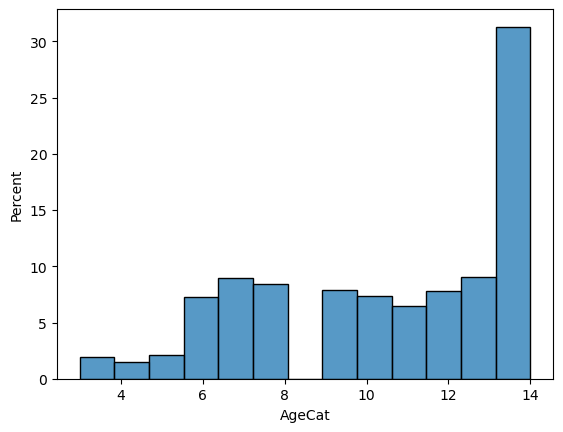

In [10]:
# plot variables to understand sample in BES survey
sns.histplot(data=final_df, x='AgeCat',stat='percent')

<Axes: xlabel='ONSed', ylabel='Percent'>

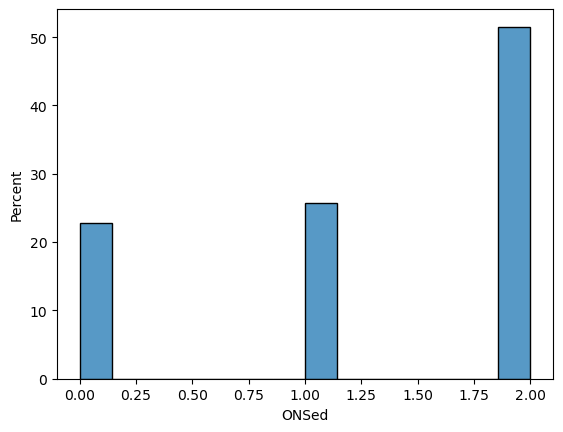

In [6]:
sns.histplot(data=final_df, x='ONSed',stat='percent')

<Axes: xlabel='SexCat', ylabel='Percent'>

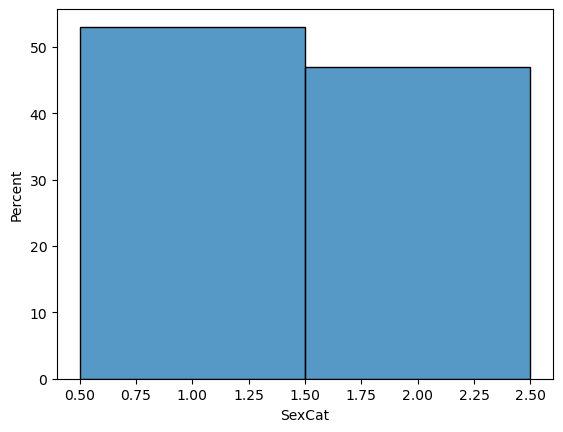

In [7]:
sns.histplot(data=final_df, x='SexCat',stat='percent')

<Axes: xlabel='TO', ylabel='Percent'>

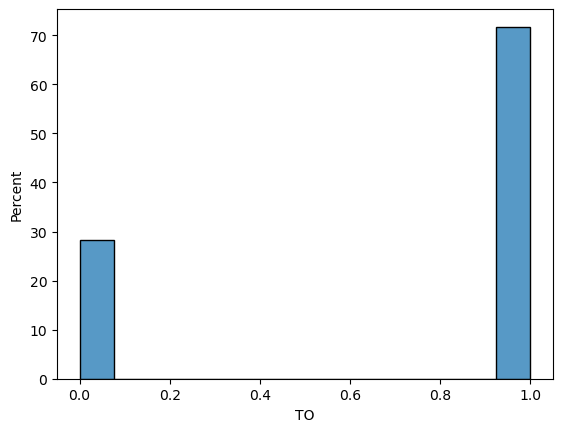

In [8]:
sns.histplot(data=final_df, x='TO',stat='percent')

<Axes: xlabel='Vote', ylabel='Percent'>

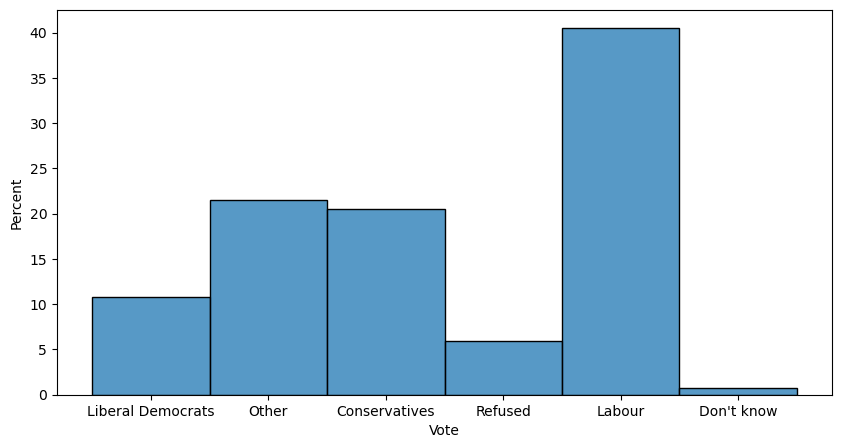

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.histplot(data=final_df[final_df["TO"]==1], x='Vote',stat='percent')